In [28]:
import heapq
import time
import json
from tqdm import tqdm
import numpy as np
import copy
from matplotlib import pyplot as plt

In [2]:
with open("config.json", "r") as file:
    config = json.load(file)

print(config)

{'no_change_stop': 8, 'population_size': 10, 'keep_best': 5, 'selection_config': {'method': 'random', 'softmax': 1, 'temperature': 2}, 'parent_selection_config': {'method': 'outbreeding', 'skip_parent_probability': 0.2}, 'truncation_config': {'method': 'random', 'softmax': 1, 'temperature': 2, 'alpha': 0.5}, 'expansion_config': {'method': 'random', 'softmax': 1, 'temperature': 2, 'alpha': 0.5}, 'mutation_config': {'mutation_probability': 0.5, 'mutation_strength': 0.1}}


In [3]:
class Individual:
    def __init__(self, nodes, weight):
        self.nodes = set(nodes)
        self.weight = weight

    def __str__(self):
        return f"{self.nodes}, weight: {self.weight}"

    def __repr__(self):
        return f"{self.nodes}, weight: {self.weight}"

    def __eq__(self, other):
        return self.nodes == other.nodes

    def __lt__(self, other):
        return self.weight < other.weight

    def __hash__(self):
        return hash(tuple(self.nodes))


In [4]:
class Population:
    def __init__(self, individuals):
        self.individuals = individuals
        self.weights = np.zeros(len(individuals))
        self.total_weight = 0
        for i, individual in enumerate(individuals):
            self.weights[i] = individual.weight
            self.total_weight += individual.weight

    def add_individual(self, individual):
        self.individuals.append(individual)
        self.total_weight += individual.weight
        self.weights = np.append(self.weights, individual.weight)

    def size(self):
        return len(self.individuals)

    def __repr__(self):
        return "\n".join([str(individual) for individual in self.individuals])

    def __getitem__(self, item):
        return self.individuals[item]

    def get_best(self, n):

        unique_sequences = set()
        individuals = []
        indexes = []

        for i, individual in enumerate(self.individuals):
            if tuple(individual.nodes) not in unique_sequences:
                unique_sequences.add(tuple(individual.nodes))
                individuals.append(individual)
                indexes.append(i)

        weights = [ind.weight for ind in individuals]
        best_idx = np.argsort(weights)[-n:]

        return [individuals[i] for i in best_idx]

In [5]:
class ConfigParser:

    def __init__(self, config):
        self.config = config

    def get_selection_function(self):
        selection_function_config = self.config["selection_config"]
        if selection_function_config["method"] == "tournament":
            return selection_tournament
        elif selection_function_config["method"] == "random":
            return lambda x: selection_random(x, selection_function_config["softmax"],
                                              selection_function_config["temperature"])
        elif selection_function_config["method"] == "sigma_truncation":
            return selection_sigma_truncation
        else:
            raise ValueError(f"Unknown selection method: {selection_function_config['method']}")

    def get_parent_selection_function(self):
        parent_selection_function_config = self.config["parent_selection_config"]
        if parent_selection_function_config["method"] == "panmixia":
            return parent_selection_panmixia
        elif parent_selection_function_config["method"] == "inbreeding":
            return lambda x: parent_selection_inbreeding(x, parent_selection_function_config["skip_parent_probability"])
        elif parent_selection_function_config["method"] == "outbreeding":
            return lambda x: parent_selection_outbreeding(x,
                                                          parent_selection_function_config["skip_parent_probability"])
        else:
            raise ValueError(f"Unknown parent selection method: {parent_selection_function_config['method']}")

    def get_truncation_function(self):
        truncation_function_config = self.config["truncation_config"]
        if truncation_function_config["method"] == "greedy":
            return truncation_greedy
        elif truncation_function_config["method"] == "random":
            return lambda x, y: truncation_random(x, y,
                                                  truncation_function_config["softmax"],
                                                  truncation_function_config["temperature"],
                                                  truncation_function_config["alpha"])
        else:
            raise ValueError(f"Unknown truncation method: {truncation_function_config['method']}")

    def get_expansion_function(self):
        expansion_function_config = self.config["expansion_config"]
        if expansion_function_config["method"] == "greedy":
            return expansion_greedy
        elif expansion_function_config["method"] == "random":
            return lambda x, y, z: expansion_random(x, y, z,
                                                    expansion_function_config["softmax"],
                                                    expansion_function_config["temperature"],
                                                    expansion_function_config["alpha"])
        else:
            raise ValueError(f"Unknown truncation method: {expansion_function_config['method']}")

    def get_mutation_function(self):
        mutation_function_config = self.config["mutation_config"]
        return lambda x, y: mutation(x, y, mutation_function_config["mutation_probability"], mutation_function_config["mutation_strength"])


In [6]:
def create_individual(matrix: np.ndarray, weights: np.ndarray):
    result = []
    indexes = np.arange(0, matrix.shape[0], dtype=int)

    while indexes.size > 0:
        idx = np.random.randint(0, indexes.size)
        result.append(indexes[idx])

        tmp = np.where(matrix[idx] == 1)
        indexes = np.delete(indexes, tmp, 0)
        matrix = np.delete(np.delete(matrix, tmp, 0), tmp, 1)

    return Individual(sorted(result), np.sum(weights[result]))


def create_population(matrix: np.ndarray, weights: np.ndarray, population_size=20):
    return Population([create_individual(matrix, weights) for _ in range(population_size)])

In [7]:
def softmax(x, temperature=1.):
    tmp = np.exp(x / temperature)
    return tmp / np.sum(tmp)


def selection_tournament(population: Population):
    weights = population.weights

    indexes = np.arange(0, population.size(), dtype=int)
    np.random.shuffle(indexes)

    result = []

    for i in range(indexes.size // 2):
        result.append(population[i] if weights[i] > weights[-i - 1] else population[-i - 1])

    return Population(result)


def selection_random(population: Population, use_softmax=True, temperature=1.):
    weights = population.weights

    if use_softmax:
        p = softmax(weights, temperature)
    else:
        p = weights / np.sum(weights)

    result = np.random.choice(population.individuals, population.size() // 2, replace=False, p=p)

    return Population(list(result))


def selection_sigma_truncation(population):
    weights = population.weights

    mean = np.mean(weights)
    std = np.std(weights)

    F = weights.max() + (weights - mean) / (2 * std + 1e-5)

    p = F / np.sum(F)

    result = np.random.choice(population.individuals, population.size() // 2, replace=False, p=p)

    return Population(list(result))


In [55]:
def parent_selection_panmixia(population):
    result = []

    indexes = np.arange(0, population.size(), dtype=int)

    for _ in range(population.size()):
        first_parent_index, second_parent_index = np.random.choice(indexes, 2, replace=False)
        result.append((population[first_parent_index], population[second_parent_index]))

    return result


def parent_selection_inbreeding(population: Population, skip_p=0.):
    result = []
    first_parent_indexes = np.random.randint(0, population.size(), population.size())

    for first_parent_index in first_parent_indexes:

        min_diff = 10000
        min_diff_idx = 0

        for second_parent_index in range(population.size()):
            if first_parent_index == second_parent_index:
                continue

            if np.random.random() < skip_p:
                continue

            diff = len(population[first_parent_index].nodes.symmetric_difference(population[second_parent_index].nodes))

            if diff < min_diff:
                min_diff = diff
                min_diff_idx = second_parent_index

        result.append((population[first_parent_index], population[min_diff_idx]))

    return result


def parent_selection_outbreeding(population: Population, skip_p=0.):
    result = []
    first_parent_indexes = np.random.randint(0, population.size(), population.size())

    for first_parent_index in first_parent_indexes:

        max_diff = 0
        max_diff_idx = 0

        for second_parent_index in range(population.size()):
            if first_parent_index == second_parent_index:
                continue

            if np.random.random() < skip_p:
                continue

            diff = len(population[first_parent_index].nodes.symmetric_difference(population[second_parent_index].nodes))

            if diff > max_diff:
                max_diff = diff
                max_diff_idx = second_parent_index

        result.append((population[first_parent_index], population[max_diff_idx]))

    return result

In [56]:
def truncation_greedy(matrix, weights):
    matrix = np.copy(matrix)

    if matrix[0, 0]:
        matrix -= np.eye(matrix.shape[0], dtype=int)

    deleted_indexes = []

    while matrix.sum() > 0:
        current_node = np.argmax(matrix.sum(axis=0) / (weights + 1e-5))
        matrix[current_node] = 0
        matrix[:, current_node] = 0
        deleted_indexes.append(current_node)

    return set(range(matrix.shape[0])).difference(set(deleted_indexes))


def truncation_random(matrix, weights, use_softmax=True, temperature=1., alpha=1.):
    matrix = np.copy(matrix)

    if matrix[0, 0]:
        matrix -= np.eye(matrix.shape[0], dtype=int)

    deleted_indexes = []

    indexes = np.arange(0, matrix.shape[0], dtype=int)

    while matrix.sum() > 0:

        coefs = matrix.sum(0) - alpha * weights

        if use_softmax:
            p = softmax(coefs, temperature)
            current_node = np.random.choice(indexes, p=p)
        else:
            current_node = indexes[np.random.randint(0, indexes.size)]

        matrix[current_node] = 0
        matrix[:, current_node] = 0
        deleted_indexes.append(current_node)

    return set(indexes).difference(set(deleted_indexes))


def expansion_greedy(indexes, matrix, weights):
    candidates = set(np.arange(0, matrix.shape[0], dtype=int))
    indexes_to_delete = set()

    for idx in indexes:
        indexes_to_delete.update(set(*np.where(matrix[idx] == 1)))

    candidates = np.array(list(candidates.difference(indexes_to_delete)))

    while len(candidates) > 0:
        sub_matrix = matrix[candidates]
        sub_matrix = sub_matrix[:, candidates]
        sub_weights = weights[candidates]
        current_node = np.argmin(sub_matrix.sum(axis=0) / (sub_weights + 1e-5))
        indexes.append(candidates[current_node])
        candidates = np.delete(candidates, np.where(sub_matrix[current_node] == 1), 0)

    return indexes


choice_time_expand = 0


def expansion_random(indexes, matrix, weights, use_softmax=True, temperature=1., alpha=1.):
    candidates = set(np.arange(0, matrix.shape[0], dtype=int))
    indexes_to_delete = set()

    for idx in indexes:
        indexes_to_delete.update(set(*np.where(matrix[idx] == 1)))

    candidates = np.array(list(candidates.difference(indexes_to_delete)))

    while len(candidates) > 0:
        sub_matrix = matrix[candidates]
        sub_matrix = sub_matrix[:, candidates]
        sub_weights = weights[candidates]

        coefs = alpha * sub_weights - sub_matrix.sum(axis=0)

        if use_softmax:
            p = softmax(coefs, temperature)
            current_node = np.random.choice(np.arange(0, sub_matrix.shape[0], dtype=int), p=p)
        else:
            current_node = np.random.randint(0, sub_matrix.shape[0])

        indexes.append(candidates[current_node])
        candidates = np.delete(candidates, np.where(sub_matrix[current_node] == 1), 0)

    return indexes


def mutation(nodes_list, max_node_idx, probability=0.1, strength=0.1):
    if np.random.random() < probability:
        return nodes_list

    nodes_number_to_add = np.random.randint(0, np.ceil(max_node_idx * strength))
    nodes_number_to_remove = np.random.randint(0, np.ceil(max_node_idx * strength))

    nodes_not_included = list(set(range(max_node_idx)).difference(set(nodes_list)))
    nodes_to_add = np.random.choice(nodes_not_included, replace=False,
                                    size=min(nodes_number_to_add, len(nodes_not_included)))
    nodes_list.extend(list(nodes_to_add))

    np.random.shuffle(nodes_list)
    nodes_list = list(nodes_list[nodes_number_to_remove:])

    return nodes_list

In [57]:
config_parser = ConfigParser(config)

selection_function = config_parser.get_selection_function()
parent_selection_function = config_parser.get_parent_selection_function()
truncation_function = config_parser.get_truncation_function()
expansion_function = config_parser.get_expansion_function()
mutation_function = config_parser.get_mutation_function()

In [58]:
def breed(lhs: Individual, rhs: Individual, matrix: np.ndarray, weights: np.ndarray):
    all_nodes = list(lhs.nodes.union(rhs.nodes))

    all_nodes = mutation_function(all_nodes, matrix.shape[0])

    sub_matrix = matrix[all_nodes]
    sub_matrix = sub_matrix[:, all_nodes]

    sub_weights = weights[all_nodes]

    truncated = np.array(all_nodes)[list(truncation_function(sub_matrix, sub_weights))]

    expanded_nodes = expansion_function(list(truncated), matrix, weights)

    return Individual(expanded_nodes, np.sum(weights[expanded_nodes]))


def breed_all_parents(parents, matrix, weights):
    result = []
    for lhs, rhs in parents:
        result.append(breed(lhs, rhs, matrix, weights))

    return result

In [59]:
def genetic_algorithm(matrix, weights):

    population = create_population(matrix, weights, config["population_size"])

    no_change = 0

    unique_bodies = set()
    top_scores_heap = []

    while no_change < config["no_change_stop"]:
        parents = parent_selection_function(population)
        children = breed_all_parents(parents, matrix, weights)

        for child in children:
            population.add_individual(child)

        population = selection_function(population)

        print(population.size())

        previous_top_three = copy.deepcopy(top_scores_heap)

        for individual in population.individuals:
            if tuple(individual.nodes) not in unique_bodies:
                unique_bodies.add(tuple(individual.nodes))
                if len(top_scores_heap) < config["keep_best"]:
                    heapq.heappush(top_scores_heap, individual)
                else:
                    heapq.heappushpop(top_scores_heap, individual)

        top_scores_heap.sort(reverse=False)

        if previous_top_three == top_scores_heap:
            no_change += 1
        else:
            no_change = 0

    return top_scores_heap


In [60]:
compatibility_matrix = np.array([
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

adjacency_matrix = 1 - compatibility_matrix - compatibility_matrix.T
weights = np.array(
    [6.7871, 0.4965, 0.5813, 6.3638, 7.7534, 6.7388, 2.1945, 5.7203, 2.5396, 0.039, 12.3052, 5.3397, 0.7031, 4.5140,
     1.4971, 5.8530, 1.8569, 3.5543, 1.9219, 11.8509, 2.2925, 5.1243, 9.2748, 2.9068, 5.4177, 3.3817, 3.5976, 0.5599])

In [61]:
print(adjacency_matrix)

[[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 

In [62]:
genetic_algorithm(adjacency_matrix, weights)

40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40


[{2, 3, 4, 5, 9, 10, 11, 12, 13, 15, 16, 18, 19, 22, 24, 25, 26, 27}, weight: 88.05269999999999,
 {2, 3, 4, 5, 10, 11, 12, 13, 15, 17, 18, 19, 22, 24, 25, 26}, weight: 89.1512,
 {0, 3, 4, 5, 10, 11, 12, 13, 17, 18, 19, 22, 24, 25, 26}, weight: 89.50399999999998,
 {0, 3, 4, 5, 9, 10, 11, 12, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27}, weight: 91.92259999999999,
 {0, 3, 4, 5, 9, 10, 11, 12, 13, 16, 18, 19, 21, 22, 24, 25, 26, 27}, weight: 93.5298]

In [135]:
%%timeit

genetic_algorithm(adjacency_matrix, weights)

87.5 ms ± 7.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
test_matrix = [
    np.array([
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ]),

]

In [41]:
with open("examples_28.txt", "r") as file:
    data = file.read()


In [42]:
weights_info = data.split("w =")[1:]

all_weights = []

for weight_info in weights_info:
    all_weights.append(weight_info.split("\n")[1])
    all_weights[-1] = all_weights[-1].split()
    all_weights[-1] = np.array(list(map(float, all_weights[-1])))

In [43]:
matrixes_info = data.split("TH compatibility matrix:")[1:]

all_matrixes = []

for matrix_info in matrixes_info:
    all_matrixes.append(matrix_info.split("Complete search (recursion):")[0])
    all_matrixes[-1] = all_matrixes[-1].split("\n")[1:-2]
    tmp = []
    for line in all_matrixes[-1]:
        tmp.append(list(map(int, line.split())))
    all_matrixes[-1] = np.array(tmp)

for i in range(len(all_matrixes)):
    all_matrixes[i] = 1 - all_matrixes[i] - all_matrixes[i].T

In [44]:
answers_info = data.split("Complete search (recursion):")[1:]

answers = []
for answer_info in answers_info:
    answers.append(answer_info.split("GH")[2:])
    tmp = []
    for answer in answers[-1][:5]:
        tmp.append(float(answer.split()[-1]))
    answers[-1] = np.array(tmp)


In [18]:
n_train = 7

matrixes_train = all_matrixes[:n_train]
weights_train = all_weights[:n_train]
answers_train = answers[:n_train]

In [ ]:
n_iter = 40


def genetic_algorithm_test(no_change_stop, population_size, keep_best, selection_function, parent_selection_function, truncation_function, expansion_function, mutation_function):

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):

        for i in range(n_iter):

            population = create_population(matrix, weights, population_size)

            no_change = 0

            unique_bodies = set()
            top_scores_heap = []

            while no_change < no_change_stop:
                selected_population = selection_function(population)
                parents = parent_selection_function(population)

                children = []
                for lhs, rhs in parents:
                    all_nodes = list(lhs.nodes.union(rhs.nodes))

                    all_nodes = mutation_function(all_nodes, matrix.shape[0])

                    sub_matrix = matrix[all_nodes]
                    sub_matrix = sub_matrix[:, all_nodes]

                    sub_weights = weights[all_nodes]

                    truncated = np.array(all_nodes)[list(truncation_function(sub_matrix, sub_weights))]

                    expanded_nodes = expansion_function(list(truncated), matrix, weights)

                    children.append(Individual(expanded_nodes, np.sum(weights[expanded_nodes])))

                for child in children:
                    selected_population.add_individual(child)

                population = selected_population

                previous_top_three = copy.deepcopy(top_scores_heap)

                for individual in population.individuals:
                    if tuple(individual.nodes) not in unique_bodies:
                        unique_bodies.add(tuple(individual.nodes))
                        if len(top_scores_heap) < keep_best:
                            heapq.heappush(top_scores_heap, individual)
                        else:
                            heapq.heappushpop(top_scores_heap, individual)

                top_scores_heap.sort(reverse=False)

                if previous_top_three == top_scores_heap:
                    no_change += 1
                else:
                    no_change = 0





In [45]:
def accuracy(preds, y):
    errors = 0
    for el in preds:
        if np.any(np.abs(y - el) < 1e-3):
            continue
        errors += 1

    return 1 - errors / len(preds)

In [163]:
with open("config.json", "r") as file:
    config = json.load(file)

print(config)

{'no_change_stop': 8, 'population_size': 10, 'keep_best': 5, 'selection_config': {'method': 'random', 'softmax': 1, 'temperature': 2}, 'parent_selection_config': {'method': 'outbreeding', 'skip_parent_probability': 0.2}, 'truncation_config': {'method': 'random', 'softmax': 1, 'temperature': 2, 'alpha': 0.5}, 'expansion_config': {'method': 'random', 'softmax': 1, 'temperature': 2, 'alpha': 0.5}, 'mutation_config': {'mutation_probability': 0.3, 'mutation_strength': 0.1}}


In [134]:
t_selection = {}
accuracies_selection = {}

for selection_method in ["tournament", "random", "sigma_truncation"]:

    t_selection[selection_method] = []
    accuracies_selection[selection_method] = []

    config["selection_config"]["method"] = selection_method

    config_parser = ConfigParser(config)

    selection_function = config_parser.get_selection_function()
    parent_selection_function = config_parser.get_parent_selection_function()
    truncation_function = config_parser.get_truncation_function()
    expansion_function = config_parser.get_expansion_function()
    mutation_function = config_parser.get_mutation_function()

    n_iter = 40

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
        for i in tqdm(list(range(n_iter))):
            start_time = time.time()
            result = genetic_algorithm(matrix, weights)
            t_selection[selection_method].append(time.time() - start_time)
            accuracies_selection[selection_method].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 40/40 [00:03<00:00, 12.82it/s]


In [135]:
from matplotlib import pyplot as plt

In [63]:
plt.boxplot([t_selection["tournament"],
             t_selection["random"],
             t_selection["sigma_truncation"]], labels=["tournament", "random", "sigma_truncation"])

plt.ylabel("Скорость работы, с")
plt.grid()
plt.show()

NameError: name 't_selection' is not defined

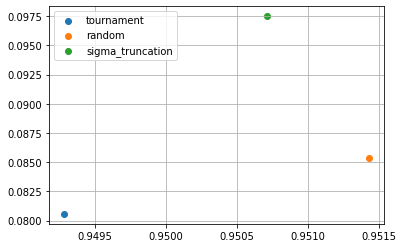

In [141]:
plt.scatter(np.mean(accuracies_selection["tournament"]), np.mean(t_selection["tournament"]), label="tournament")
plt.scatter(np.mean(accuracies_selection["random"]), np.mean(t_selection["random"]), label="random")
plt.scatter(np.mean(accuracies_selection["sigma_truncation"]), np.mean(t_selection["sigma_truncation"]), label="sigma_truncation")
plt.grid()
plt.legend()
plt.show()

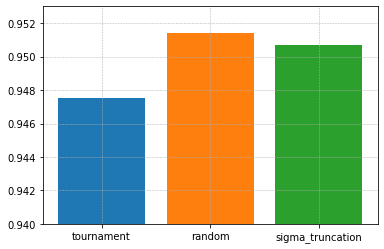

In [75]:
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.bar("tournament", 0.9475)
plt.bar("random", 0.9514)
plt.bar("sigma_truncation", 0.9507)
plt.ylim(0.94, 0.953)
plt.show()

In [143]:
t_parent_selection = {}
accuracies_parent_selection = {}

for parent_selection_method in ["panmixia", "inbreeding", "outbreeding"]:

    t_parent_selection[parent_selection_method] = []
    accuracies_parent_selection[parent_selection_method] = []

    config["parent_selection_config"]["method"] = parent_selection_method

    config_parser = ConfigParser(config)

    selection_function = config_parser.get_selection_function()
    parent_selection_function = config_parser.get_parent_selection_function()
    truncation_function = config_parser.get_truncation_function()
    expansion_function = config_parser.get_expansion_function()
    mutation_function = config_parser.get_mutation_function()

    n_iter = 40

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
        for i in tqdm(list(range(n_iter))):
            start_time = time.time()
            result = genetic_algorithm(matrix, weights)
            t_parent_selection[parent_selection_method].append(time.time() - start_time)
            accuracies_parent_selection[parent_selection_method].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 40/40 [00:03<00:00, 13.10it/s]


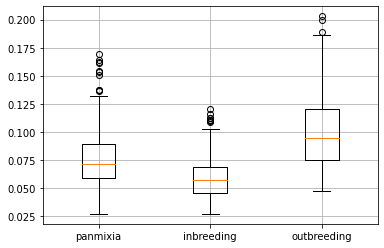

In [144]:
plt.boxplot([t_parent_selection["panmixia"],
             t_parent_selection["inbreeding"],
             t_parent_selection["outbreeding"]], labels=["panmixia", "inbreeding", "outbreeding"])

plt.grid()
plt.show()

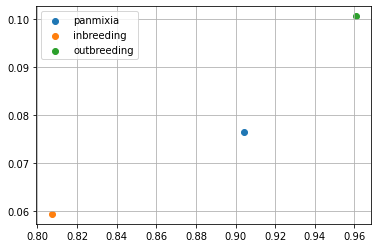

In [145]:
plt.scatter(np.mean(accuracies_parent_selection["panmixia"]), np.mean(t_parent_selection["panmixia"]), label="panmixia")
plt.scatter(np.mean(accuracies_parent_selection["inbreeding"]), np.mean(t_parent_selection["inbreeding"]), label="inbreeding")
plt.scatter(np.mean(accuracies_parent_selection["outbreeding"]), np.mean(t_parent_selection["outbreeding"]), label="outbreeding")
plt.grid()
plt.legend()
plt.show()

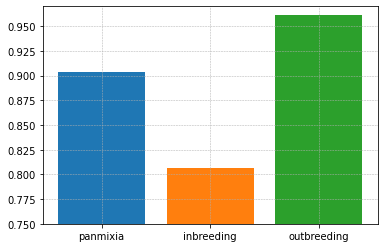

In [76]:
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.bar("panmixia", 0.904)
plt.bar("inbreeding", 0.806)
plt.bar("outbreeding", 0.961)
plt.ylim(0.75, 0.97)
plt.show()

In [149]:
t_breeding = {}
accuracies_breeding = {}

for truncation_method in ["greedy", "random"]:
    for expansion_method in ["greedy", "random"]:

        current_name = truncation_method + "-" + expansion_method

        t_breeding[current_name] = []
        accuracies_breeding[current_name] = []

        config["truncation_config"]["method"] = truncation_method
        config["expansion_config"]["method"] = expansion_method

        config_parser = ConfigParser(config)

        selection_function = config_parser.get_selection_function()
        parent_selection_function = config_parser.get_parent_selection_function()
        truncation_function = config_parser.get_truncation_function()
        expansion_function = config_parser.get_expansion_function()
        mutation_function = config_parser.get_mutation_function()

        n_iter = 40

        for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
            for i in tqdm(list(range(n_iter))):
                start_time = time.time()
                result = genetic_algorithm(matrix, weights)
                t_breeding[current_name].append(time.time() - start_time)
                accuracies_breeding[current_name].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 40/40 [00:03<00:00, 12.39it/s]


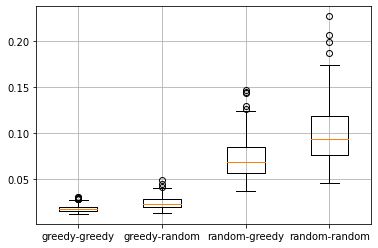

In [151]:
plt.boxplot([t_breeding["greedy-greedy"],
             t_breeding["greedy-random"],
             t_breeding["random-greedy"],
             t_breeding["random-random"]], labels=["greedy-greedy", "greedy-random", "random-greedy", "random-random"])

plt.grid()
plt.show()

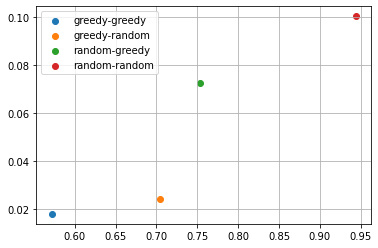

In [152]:
plt.scatter(np.mean(accuracies_breeding["greedy-greedy"]), np.mean(t_breeding["greedy-greedy"]), label="greedy-greedy")
plt.scatter(np.mean(accuracies_breeding["greedy-random"]), np.mean(t_breeding["greedy-random"]), label="greedy-random")
plt.scatter(np.mean(accuracies_breeding["random-greedy"]), np.mean(t_breeding["random-greedy"]), label="random-greedy")
plt.scatter(np.mean(accuracies_breeding["random-random"]), np.mean(t_breeding["random-random"]), label="random-random")
plt.grid()
plt.legend()
plt.show()

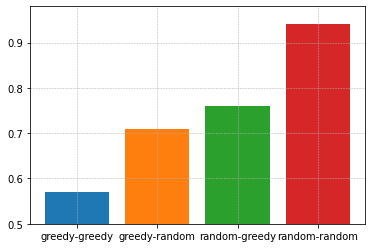

In [77]:
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.bar("greedy-greedy", 0.57)
plt.bar("greedy-random", 0.71)
plt.bar("random-greedy", 0.76)
plt.bar("random-random", 0.94)
plt.ylim(0.5, 0.98)
plt.show()

In [154]:
t_no_change = {}
accuracies_no_change = {}

for no_change in range(3, 20):
    for expansion_method in ["greedy", "random"]:

        t_no_change[no_change] = []
        accuracies_no_change[no_change] = []

        config["no_change_stop"] = no_change

        config_parser = ConfigParser(config)

        selection_function = config_parser.get_selection_function()
        parent_selection_function = config_parser.get_parent_selection_function()
        truncation_function = config_parser.get_truncation_function()
        expansion_function = config_parser.get_expansion_function()
        mutation_function = config_parser.get_mutation_function()

        n_iter = 40

        for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
            for i in tqdm(list(range(n_iter))):
                start_time = time.time()
                result = genetic_algorithm(matrix, weights)
                t_no_change[no_change].append(time.time() - start_time)
                accuracies_no_change[no_change].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 40/40 [00:04<00:00,  8.12it/s]


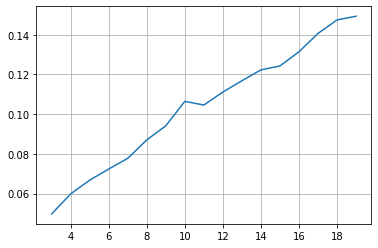

In [156]:
plt.plot(list(t_no_change.keys()), [np.mean(res) for res in t_no_change.values()])
plt.grid()
plt.show()

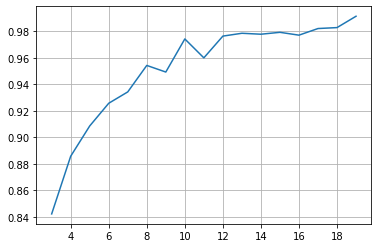

In [157]:
plt.plot(list(accuracies_no_change.keys()), [np.mean(res) for res in accuracies_no_change.values()])
plt.grid()
plt.show()

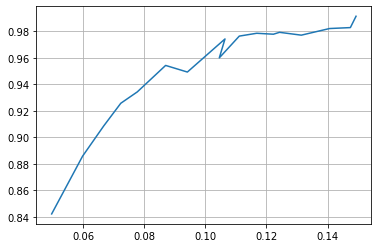

In [158]:
plt.plot([np.mean(res) for res in t_no_change.values()], [np.mean(res) for res in accuracies_no_change.values()])
plt.grid()
plt.show()

In [159]:
t_population_size = {}
accuracies_population_size = {}

for population_size in tqdm(range(4, 31, 2)):

    t_population_size[population_size] = []
    accuracies_population_size[population_size] = []

    config["population_size"] = population_size

    config_parser = ConfigParser(config)

    selection_function = config_parser.get_selection_function()
    parent_selection_function = config_parser.get_parent_selection_function()
    truncation_function = config_parser.get_truncation_function()
    expansion_function = config_parser.get_expansion_function()
    mutation_function = config_parser.get_mutation_function()

    n_iter = 40

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
        for i in list(range(n_iter)):
            start_time = time.time()
            result = genetic_algorithm(matrix, weights)
            t_population_size[population_size].append(time.time() - start_time)
            accuracies_population_size[population_size].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 14/14 [18:08<00:00, 77.75s/it] 


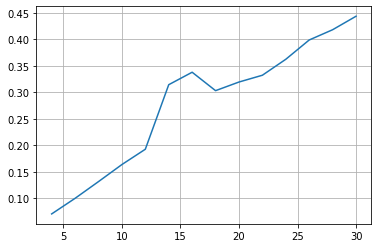

In [160]:
plt.plot(list(t_population_size.keys()), [np.mean(res) for res in t_population_size.values()])
plt.grid()
plt.show()

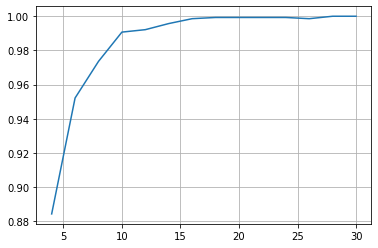

In [161]:
plt.plot(list(accuracies_population_size.keys()), [np.mean(res) for res in accuracies_population_size.values()])
plt.grid()
plt.show()

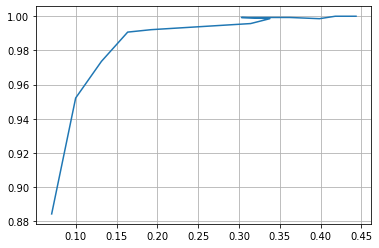

In [162]:
plt.plot([np.mean(res) for res in t_population_size.values()], [np.mean(res) for res in accuracies_population_size.values()])
plt.grid()
plt.show()

In [164]:
t_mutation = {}
accuracies_mutation = {}

for mutation_p in tqdm(np.arange(0, 1.05, 0.1)):

    t_mutation[mutation_p] = []
    accuracies_mutation[mutation_p] = []

    with open("config.json", "r") as file:
        config = json.load(file)
    config["mutation_config"]["mutation_probability"] = mutation_p

    config_parser = ConfigParser(config)

    selection_function = config_parser.get_selection_function()
    parent_selection_function = config_parser.get_parent_selection_function()
    truncation_function = config_parser.get_truncation_function()
    expansion_function = config_parser.get_expansion_function()
    mutation_function = config_parser.get_mutation_function()

    n_iter = 40

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
        for i in list(range(n_iter)):
            start_time = time.time()
            result = genetic_algorithm(matrix, weights)
            t_mutation[mutation_p].append(time.time() - start_time)
            accuracies_mutation[mutation_p].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 11/11 [04:34<00:00, 24.95s/it]


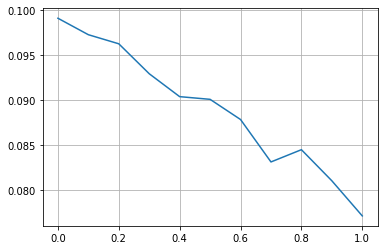

In [165]:
plt.plot(list(t_mutation.keys()), [np.mean(res) for res in t_mutation.values()])
plt.grid()
plt.show()

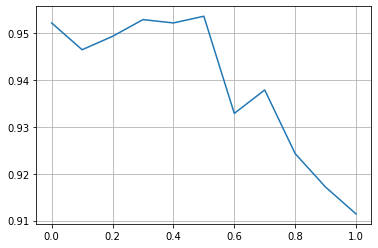

In [166]:
plt.plot(list(accuracies_mutation.keys()), [np.mean(res) for res in accuracies_mutation.values()])
plt.grid()
plt.show()

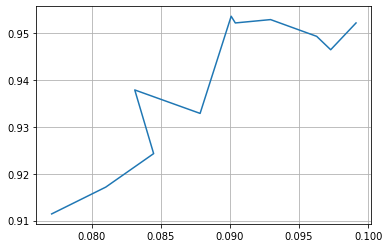

In [167]:
plt.plot([np.mean(res) for res in t_mutation.values()], [np.mean(res) for res in accuracies_mutation.values()])
plt.grid()
plt.show()

In [179]:
t_softmax = {}
accuracies_softmax = {}

for truncation_softmax in [1, 0]:
    for expansion_softmax in [1, 0]:

        current_name = ("no", "yes")[truncation_softmax] + "-" + ("no", "yes")[expansion_softmax]

        t_softmax[current_name] = []
        accuracies_softmax[current_name] = []

        with open("config.json", "r") as file:
            config = json.load(file)
        config["truncation_config"]["softmax"] = truncation_softmax
        config["expansion_config"]["softmax"] = expansion_softmax

        config_parser = ConfigParser(config)

        selection_function = config_parser.get_selection_function()
        parent_selection_function = config_parser.get_parent_selection_function()
        truncation_function = config_parser.get_truncation_function()
        expansion_function = config_parser.get_expansion_function()
        mutation_function = config_parser.get_mutation_function()

        n_iter = 40

        for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
            for i in tqdm(list(range(n_iter))):
                start_time = time.time()
                result = genetic_algorithm(matrix, weights)
                t_softmax[current_name].append(time.time() - start_time)
                accuracies_softmax[current_name].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


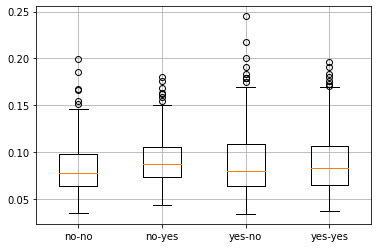

In [180]:
plt.boxplot([t_softmax["no-no"],
             t_softmax["no-yes"],
             t_softmax["yes-no"],
             t_softmax["yes-yes"]], labels=["no-no", "no-yes", "yes-no", "yes-yes"])

plt.grid()
plt.show()

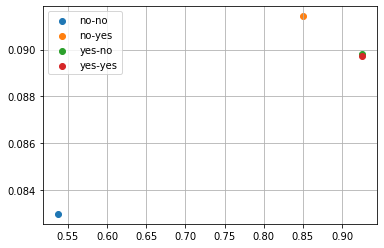

In [182]:
plt.scatter(np.mean(accuracies_softmax["no-no"]), np.mean(t_softmax["no-no"]), label="no-no")
plt.scatter(np.mean(accuracies_softmax["no-yes"]), np.mean(t_softmax["no-yes"]), label="no-yes")
plt.scatter(np.mean(accuracies_softmax["yes-no"]), np.mean(t_softmax["yes-no"]), label="yes-no")
plt.scatter(np.mean(accuracies_softmax["yes-yes"]), np.mean(t_softmax["yes-yes"]), label="yes-yes")
plt.grid()
plt.legend()
plt.show()

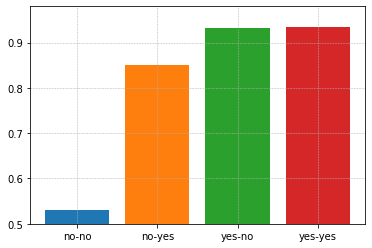

In [78]:
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.bar("no-no", 0.53)
plt.bar("no-yes", 0.85)
plt.bar("yes-no", 0.932)
plt.bar("yes-yes", 0.934)
plt.ylim(0.5, 0.98)
plt.show()

In [26]:
t_alpha = {}
accuracies_alpha = {}

for alpha in tqdm(np.arange(0, 2, 0.1)):

    t_alpha[alpha] = []
    accuracies_alpha[alpha] = []

    with open("config.json", "r") as file:
        config = json.load(file)
    config["truncation_config"]["alpha"] = alpha
    config["expansion_config"]["alpha"] = alpha

    config_parser = ConfigParser(config)

    selection_function = config_parser.get_selection_function()
    parent_selection_function = config_parser.get_parent_selection_function()
    truncation_function = config_parser.get_truncation_function()
    expansion_function = config_parser.get_expansion_function()
    mutation_function = config_parser.get_mutation_function()

    n_iter = 40

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
        for i in list(range(n_iter)):
            start_time = time.time()
            result = genetic_algorithm(matrix, weights)
            t_alpha[alpha].append(time.time() - start_time)
            accuracies_alpha[alpha].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 20/20 [29:06<00:00, 87.31s/it] 


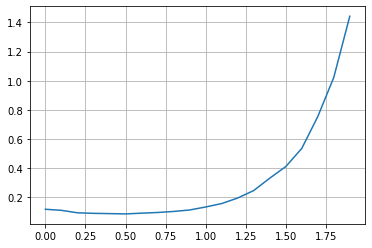

In [29]:
plt.plot(list(t_alpha.keys()), [np.mean(res) for res in t_alpha.values()])
plt.grid()
plt.show()

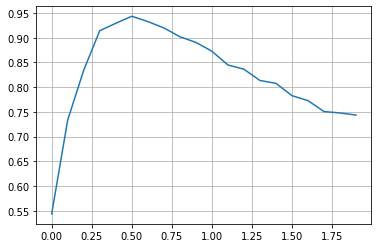

In [30]:
plt.plot(list(accuracies_alpha.keys()), [np.mean(res) for res in accuracies_alpha.values()])
plt.grid()
plt.show()

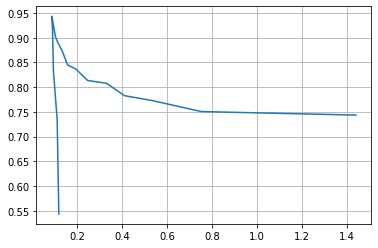

In [31]:
plt.plot([np.mean(res) for res in t_alpha.values()], [np.mean(res) for res in accuracies_alpha.values()])
plt.grid()
plt.show()

In [32]:
t_temperature = {}
accuracies_temperature = {}

for temperature in tqdm(np.arange(0.5, 4, 0.3)):

    t_temperature[temperature] = []
    accuracies_temperature[temperature] = []

    with open("config.json", "r") as file:
        config = json.load(file)
    config["truncation_config"]["temperature"] = temperature
    config["expansion_config"]["temperature"] = temperature

    config_parser = ConfigParser(config)

    selection_function = config_parser.get_selection_function()
    parent_selection_function = config_parser.get_parent_selection_function()
    truncation_function = config_parser.get_truncation_function()
    expansion_function = config_parser.get_expansion_function()
    mutation_function = config_parser.get_mutation_function()

    n_iter = 40

    for matrix, weights, answer in zip(matrixes_train, weights_train, answers_train):
        for i in list(range(n_iter)):
            start_time = time.time()
            result = genetic_algorithm(matrix, weights)
            t_temperature[temperature].append(time.time() - start_time)
            accuracies_temperature[temperature].append(accuracy(np.array([el.weight for el in result]), answer))

100%|██████████| 12/12 [07:03<00:00, 35.25s/it]


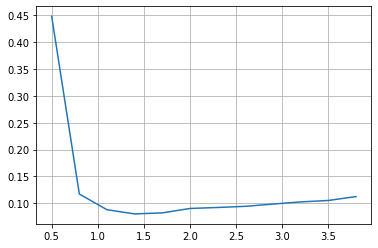

In [33]:
plt.plot(list(t_temperature.keys()), [np.mean(res) for res in t_temperature.values()])
plt.grid()
plt.show()

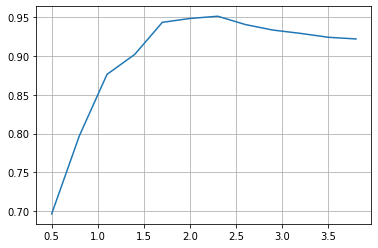

In [34]:
plt.plot(list(accuracies_temperature.keys()), [np.mean(res) for res in accuracies_temperature.values()])
plt.grid()
plt.show()

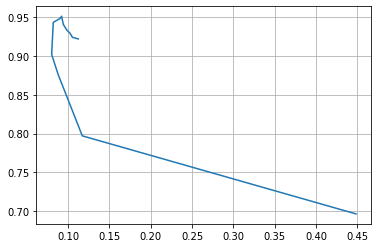

In [35]:
plt.plot([np.mean(res) for res in t_temperature.values()], [np.mean(res) for res in accuracies_temperature.values()])
plt.grid()
plt.show()

In [53]:
t = 0
accuracies = []
n_iter = 100

with open("config.json", "r") as file:
    config = json.load(file)

print(config)
config_parser = ConfigParser(config)

selection_function = config_parser.get_selection_function()
parent_selection_function = config_parser.get_parent_selection_function()
truncation_function = config_parser.get_truncation_function()
expansion_function = config_parser.get_expansion_function()
mutation_function = config_parser.get_mutation_function()

for matrix, weights, answer in zip(all_matrixes, all_weights, answers):
    for i in tqdm(list(range(n_iter))):
        start_time = time.time()
        result = genetic_algorithm(matrix, weights)
        t += time.time() - start_time
        accuracies.append(accuracy(np.array([el.weight for el in result]), answer))

{'no_change_stop': 15, 'population_size': 40, 'keep_best': 5, 'selection_config': {'method': 'tournament', 'softmax': 1, 'temperature': 2}, 'parent_selection_config': {'method': 'outbreeding', 'skip_parent_probability': 0.2}, 'truncation_config': {'method': 'greedy', 'softmax': 1, 'temperature': 2.25, 'alpha': 0.5}, 'expansion_config': {'method': 'greedy', 'softmax': 1, 'temperature': 2.25, 'alpha': 0.5}, 'mutation_config': {'mutation_probability': 0.5, 'mutation_strength': 0.1}}


100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


In [54]:
print("mean time:", t / (n_iter * len(matrixes_train)))
print("mean accuracy:", np.mean(accuracies))

mean time: 0.12587772369384764
mean accuracy: 0.7748
